In [1]:
!pip install datasets
!pip install evaluate
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


In [2]:
# Determine whether a GPU is available, and set it to gpu if available else set it to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
file_path = 'manually_created_tos.csv'
data = pd.read_csv(file_path)
# Data Preprocessing
data = data.dropna()  # Drop missing values
data['label'] = data['label'].map({'Risky': 0, 'Safe': 1, 'Information': 2})  # Encode label

# Splitting the dataset into train and test subsets
train_texts, test_texts, train_labels, test_labels = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Convert the split data into Hugging Face Dataset format
train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_data = Dataset.from_dict({"text": test_texts, "label": test_labels})

In [4]:
# Loading the tokenizer and model
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
# Tokenizing the dataset
def preprocess_function(review):
    return tokenizer(review["text"], truncation=True, padding="max_length", max_length=512)

In [6]:
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

tokenized_train = tokenized_train.with_format("torch")
tokenized_test = tokenized_test.with_format("torch")

accuracy_metric = load("accuracy")

Map:   0%|          | 0/953 [00:00<?, ? examples/s]

Map:   0%|          | 0/239 [00:00<?, ? examples/s]

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

In [8]:
# Defining training arguments and the Trainer
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Training the model
trainer.train()

# Evaluating the model
predictions = trainer.predict(tokenized_test)
logits = predictions.predictions
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test["label"]

# Calculate probabilities (softmax on logits)
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-7bb3dbac1ce0>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.078238,0.397490
2,No log,1.035649,0.481172
3,No log,0.978636,0.510460
4,No log,0.946451,0.506276
5,No log,0.898123,0.606695
6,No log,0.887181,0.606695


In [9]:
# Calculating the accuracy and confusion matrix
accuracy = compute_metrics((predictions.predictions, true_labels))["accuracy"]
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print evaluation results
print(f"Accuracy: {accuracy}")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy: 0.606694560669456
Precision:  [0.75294118 0.49367089 0.56      ]
Recall:  [0.69565217 0.65       0.48275862]
F1 Score:  [0.72316384 0.56115108 0.51851852]


Confusion Matrix:
[[64 10 18]
 [ 6 39 15]
 [15 30 42]]


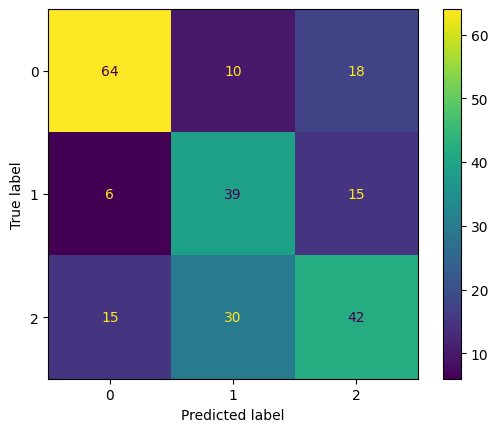

In [10]:
print(f"Confusion Matrix:\n{conf_matrix}")
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show()